### Time series analyses
Testing for Granger causality and building a time series model.

**References**: 
- https://stats.stackexchange.com/questions/160278/testing-for-granger-causality
- https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.grangercausalitytests.html
- https://www.machinelearningplus.com/time-series/time-series-analysis-python/
- https://towardsdatascience.com/machine-learning-part-19-time-series-and-autoregressive-integrated-moving-average-model-arima-c1005347b0d7
- https://towardsdatascience.com/forecasting-with-prophet-d50bbfe95f91
- https://www.tandfonline.com/doi/abs/10.1080/00031305.2017.1380080
- https://towardsdatascience.com/implementing-facebook-prophet-efficiently-c241305405a3
- https://towardsdatascience.com/time-series-forecasting-with-prophet-54f2ac5e722e
- https://github.com/eltonlaw/impyute

#### Import modules

In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fbprophet import Prophet
from dateutil import rrule, parser
import logging
logging.getLogger().setLevel(logging.ERROR)
%matplotlib inline

#### Import CSVs

In [2]:
%cd /home/lindsay/hioekg-compare-years/

nsmz_df_2013=pd.read_csv('nsmz_semidaily_df_2013.csv')
nmdz_df_2013=pd.read_csv('nmdz_semidaily_df_2013.csv')
nlgz_df_2013=pd.read_csv('nlgz_semidaily_df_2013.csv')
nsm_df_2013=pd.read_csv('nsm_semidaily_df_2013.csv')
nlg_df_2013=pd.read_csv('nlg_semidaily_df_2013.csv')

nsmz_df_2014=pd.read_csv('nsmz_semidaily_df_2014.csv')
nmdz_df_2014=pd.read_csv('nmdz_semidaily_df_2014.csv')
nlgz_df_2014=pd.read_csv('nlgz_semidaily_df_2014.csv')
nsm_df_2014=pd.read_csv('nsm_semidaily_df_2014.csv')
nlg_df_2014=pd.read_csv('nlg_semidaily_df_2014.csv')

/home/lindsay/hioekg-compare-years


#### Prepare the data

I'm working with the 2013 data first. I am interested in the date and concentration of each df.

Because the "dates" assigned to the data only really indicate the month and year- and act as helpful plotting placeholders- they are not useful for datetime object parsing, or for resample() functions. Instead, I'm slicing the df into 2 week segments: 10076 (half-day frame length) * 14  half-days = 1 week = len = 141064.

### nsmz

I considered using the KNN imputation technique, which is based on the K-Nearest Neighbours algorithm. For a given instance with missing data, KNN imputation returns n most similar neighbours and replaces the missing element with a mean or mode of the neighbours. The choice between mode and mean depends if the feature is a continuous or a categorical one. 

I decided *against* imputation ultimately. This decision was informed in part by the computational limits of my computer and the remote server. Imputation takes a very long time. Foremost, though, I thought about the reason for the existence of the negative values: they appear as the model negotiates the system-wide N balance, and appear to be an expected component of COBALT's functionality. I realized that changing them to positive means based on the values within like clusters would not reflect the true N budget over time, so instead I am changing negative values to NaNs and grouping by weeks. NaNs will be ignored in the weekly value calculations.

In [257]:
# Find the mean concentration of each week for each week over a period of 1 year
df=nsmz_df_2013[['date', 'concentration']]
df2=nsmz_df_2014[['date','concentration']]
all_frames = [df,df2]
df = pd.concat(all_frames, axis=0)

In [258]:
# Replace all negative values with NaNs
df=df.assign(concentration = df.concentration.where(df.concentration.ge(0)))

In [263]:
# Group by 7 day increments
df=df.groupby(np.arange(len(df.index))//141064).mean()
df.head()

,concentration
0,1.225938e-07
1,1.138566e-07
2,1.278411e-07
3,1.168336e-07
4,1.191120e-07


In [265]:
# Create list of weekly dates
date1 = '2013-01-02'
date2 = '2014-12-23'
date = list(rrule.rrule(rrule.WEEKLY, dtstart=parser.parse(date1), until=parser.parse(date2)))

In [268]:
# Add list to df
df=df.assign(date=date)

In [269]:
# Classify date col as datetime object
df['date'] = pd.to_datetime(df['date'])

In [270]:
# Prophet requires the datetime col name = ds, the feature var = y
df.columns = ['y', 'ds']

In [271]:
df.tail()

,y,ds
98,1.131755e-07,2014-11-19
99,1.239669e-07,2014-11-26
100,1.260907e-07,2014-12-03
101,1.078846e-07,2014-12-10
102,1.382118e-07,2014-12-17


In [272]:
# Holdout set: 40 weeks
prediction_size = 40
train_df = df[:-prediction_size]
m = Prophet()
m.fit(train_df)
future = m.make_future_dataframe(freq='W', periods=40)
forecast = m.predict(future)

- yhat: the prediction
- yhat_lower: the lower bound of prediction 
- yhat_upper: the upper bound of prediction 

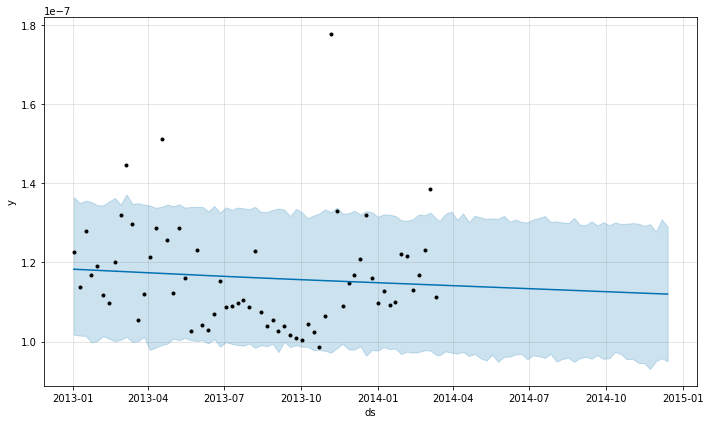

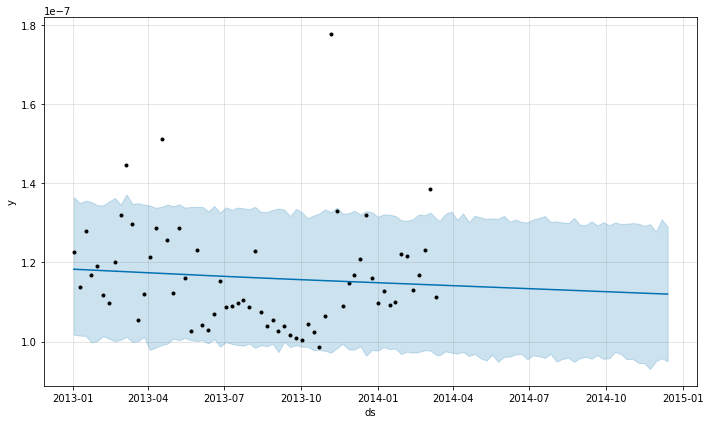

In [273]:
m.plot(forecast)

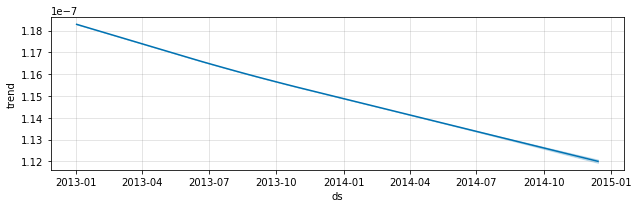

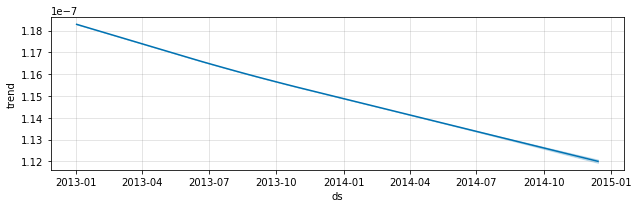

In [274]:
m.plot_components(forecast)

In [275]:
# nsmz forecast errors
def make_comparison_dataframe(historical, forecast):
    return forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(historical.set_index('ds'))

In [287]:
forecast.ds = df.ds

In [290]:
# comparison df
cmp_df = make_comparison_dataframe(df, forecast)
cmp_df.tail()

,yhat,yhat_lower,yhat_upper,y
ds,,,,
2014-11-19,1.122307e-07,9.456907e-08,1.292364e-07,1.131755e-07
2014-11-26,1.121726e-07,9.305557e-08,1.296738e-07,1.239669e-07
2014-12-03,1.121145e-07,9.503973e-08,1.278148e-07,1.260907e-07
2014-12-10,1.120565e-07,9.578945e-08,1.308604e-07,1.078846e-07
2014-12-17,1.119984e-07,9.502047e-08,1.290358e-07,1.382118e-07


In [291]:
def calculate_forecast_errors(df, prediction_size):
    
    df = df.copy() 
    df['e'] = df['y'] - df['yhat']
    df['p'] = 100 * df['e'] / df['y']  
    predicted_part = df[-prediction_size:]  
    error_mean = lambda error_name: np.mean(np.abs(predicted_part[error_name]))   
    return {'MAPE': error_mean('p'), 'MAE': error_mean('e')}


In [292]:
for err_name, err_value in calculate_forecast_errors(cmp_df, prediction_size).items():
    print(err_name, err_value)

MAPE 5.917084039110988
MAE 7.316683549733305e-09


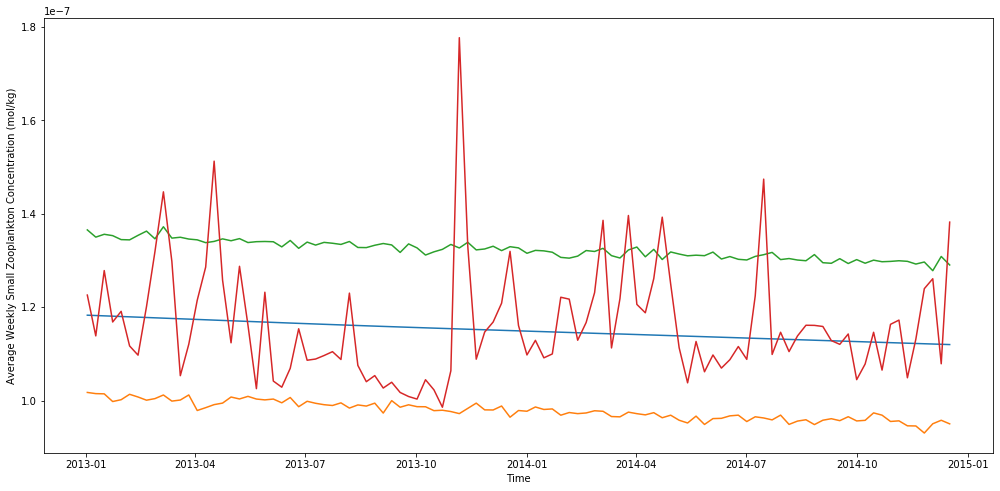

In [295]:
plt.figure(figsize=(17, 8))
plt.plot(cmp_df['yhat'])
plt.plot(cmp_df['yhat_lower'])
plt.plot(cmp_df['yhat_upper'])
plt.plot(cmp_df['y'])
plt.xlabel('Time')
plt.ylabel('Average Weekly Small Zooplankton Concentration (mol/kg)')
plt.grid(False)
plt.show()

### nmdz

I extracted semi-daily average plankton concentrations (generated at 00:00 and 12:00) for two annual cycles of COBALT in Kaneohe Bay. For each zooplankton group, I trained my Prophet time series model with the first 15 months of data. I withheld the latter 3/4 of data from 2014 for validation purposes. I wanted to explore the differences between the predicted vs. "observed" (COBALT-generated) concentrations of each zooplankton group.

**Conclusions**:

- **nsmz (small zooplankton)**: MAPE = 5.9%. No seasonal trend detected. Concentrations generally fluctuate between 1.0 - 1.4e-7 mol/kg.

- **nmdz (medium zooplankton)**: 

- **nlgz (large zooplankton)**: 